# Actividad: Modelización y resolución con Dwave

## Objetivos

El objetivo de esta actividad será construir un modelo capaz de resolver de forma sencilla el problema del viajante.

## Descripción

Se partirá del siguiente mapa:

![Mapa de ciudades](misc/graph.png)


Cada uno de estos nodos representa una ciudad que, como podemos ver, están unidas a través de una serie de carreteras (nótese que no tienen por qué existir carreteras entre todas las ciudades).

El objetivo será encontrar la ruta de mínima distancia que cumpla las siguientes características:

- El inicio de la ruta y el final debe ser el nodo 0.
- La segunda ciudad que vamos a visitar (sin contar el origen) debe ser la ciudad 2.
- Todas las ciudades deben ser visitadas.
- Solo podemos ir una vez a cada una de las ciudades.

Como podemos ver, no se ha indicado la distancia del nodo 0 al nodo 2. Da a dicha distancia la longitud que te parezca más acertada.

Por otro lado, la solución que ofrece DWave será una serie de unos y ceros. Tendrás que programar una función capaz de traducir ese dominio de solución a una lista con el número de las ciudades por orden de visita.



# Desarrollo


## Instalación de librerías
Para el desarrollo de la práctica usaremos las siguientes libreías:

- **dwave-ocean-sdk**: Esta librería proporciona herramientas y recursos para el desarrollo de algoritmos cuánticos utilizando la tecnología de annealing cuántico de D-Wave. Incluye funciones para la formulación de problemas, ejecución en el hardware cuántico de D-Wave y análisis de resultados.

- **dwave_networkx**: Una extensión de la popular librería `networkx`, diseñada para trabajar de manera integrada con la plataforma de computación cuántica de D-Wave. Permite la creación y manipulación de grafos compatibles con la infraestructura de D-Wave, facilitando la formulación y resolución de problemas cuánticos.

- **networkx**: Una potente librería de Python para el análisis y la manipulación de grafos. Proporciona una amplia gama de funciones y algoritmos para la creación, visualización y procesamiento de redes complejas, lo que la convierte en una herramienta esencial para la modelización y el estudio de sistemas interconectados.

Importaremos dichas librerías y si no están instaladas en nuestro entorno, las instalaremos

In [ ]:
try:
  from neal import SimulatedAnnealingSampler

  import networkx as nx
  import dwave_networkx as dnx

except:
  print("Libraries not available in the current session. Downloading and importing...")
  !pip install dwave-ocean-sdk dwave_networkx
  from neal import SimulatedAnnealingSampler

  import networkx as nx
  import dwave_networkx as dnx
print("Libraries imported")

Libraries imported


## Desarrollo del Problema del Viajante (Traveling Salesman Problem)

El problema del viajante, también conocido como TSP por sus siglas en inglés, es un problema clásico en la teoría de la optimización combinatoria y la ciencia de la computación.

El objetivo es minimizar la distancia total recorrida por el viajante, comenzando y terminando en la misma ciudad y pasando por cada ciudad exactamente una vez.

El TSP es un problema NP-duro, lo que significa que no existe un algoritmo eficiente conocido que pueda resolver todas las instancias del problema en tiempo polinomial.

En nuestro caso intentaremos resolver dicho problema haciendo uso de la formulación QUBO y los algoritmos de Annealing Cuántico que podemos simular en el SDK de D-Wave.



### Formulación del problema

Para resolver el problema lo primero que haremos será definir tanto la función de coste que queremos optimizar como las restricciones de nuestro caso.

- **Función de coste**: Distancia recorrida por el viajante
- **Restricciones**:
  - Cada ciudad debe ser visitada una vez
  - Debemos empezar y terminar en la misma ciudad
  - La segunda ciudad a visitar, sin contar el origen, debe de ser la 2




  ### Resolución del Problema
  Una vez definidos los elementos que componen nuestro problema lo modelaremos haciendo uso de la función `traveling_salesperson_qubo`. Esta función nos creará la formulación QUBO del problema TSP en su versión más sencilla, esto es, con las restricciones de visitar todas las ciudades una única vez y empezar y terminar en la misma ciudad.

  Sobre esta formulación añadiremos nosotros la restricción de que la segunda ciudad debería ser una que nosotros especifiquemos, en este caso, la 2.

  Para ello penalizaremos mediante un multiplicador de lagrange cualquier resultado en el que la segunda ciudad visitada no sea la que nosotros queremos.

  Además de esto, penalizaremos cualquier cuidad de origen y fin del viaje que no sea la que nosotros hemos especificado.

  Todo esto lo implementaremos a través de 2 funciones en python.

  1. `has_invalid_path(route, graph)` : Función que nos dirá si la ruta resultante es valida o no, es decir, si viaja a través de ciudades conectadas entre sí.
  2. `TSP(graph, start, second_city, lagrange, n_samples, sampler, missing_edge_weight)`: Función que implementa la resolución del problema TSP.

In [ ]:
# Check if result is valid
def has_invalid_path(route, graph):
    """
    Checks if the given route contains cities without a connecting road in the provided graph.

    Args:
    - route (list): The route to be checked, represented as a list of city indices.
    - graph (list or set): The weighted edges of the graph. Each edge should be represented as a tuple (node1, node2, weight).

    Returns:
    - bool: True if the route contains cities without a connecting road, False otherwise.
    """
    for i in range(len(route) - 1):
      city1 = route[i]
      city2 = route[i + 1]

      if not any((city1, city2, weight) in graph or (city2, city1, weight) in graph for _, _, weight in graph):
        return True
      return False


# Function to solve TSP
def TSP(graph, start, second_city, lagrange = None, n_samples = 200, sampler = SimulatedAnnealingSampler(), missing_edge_weight = None):

  """
    Solves the Traveling Salesperson Problem (TSP) using Quantum Annealing.

    Args:
    - graph (list or set): The weighted edges of the graph. Each edge should be represented as a tuple (node1, node2, weight).
    - start: The starting city.
    - second_city: The city to visit second.
    - lagrange (float): Lagrange parameter for QUBO problem formulation. If not provided, it is calculated based on the graph.
    - n_samples (int): Number of samples for the quantum annealer.
    - sampler (dimod.Sampler): Sampler for solving the QUBO problem. Default is SimulatedAnnealingSampler.
    - missing_edge_weight: Weight assigned to missing edges in the graph. If not provided, it is calculated based on the lagrange parameter.

    Returns:
    - Q (dict): The QUBO problem formulation.
    - route (list): The optimal route found by the solver.

  """

  # Create the conectivity graph
  G = nx.Graph()
  G.add_weighted_edges_from(graph)

  if lagrange is None:
        # If no lagrange parameter provided, set to 'average' tour length.
        # Usually a good estimate for a lagrange parameter is between 75-150%
        # of the objective function value, so we come up with an estimate for
        # tour length and use that.
        if G.number_of_edges()>0:
            lagrange = (G.size(weight=' weight')*G.number_of_nodes()/G.number_of_edges())**2
        else:
            lagrange = 2

      # calculate default missing_edge_weight if required
  if missing_edge_weight is None:
    if lagrange is None:
    # networkx method to calculate sum of all weights
      missing_edge_weight = G.size(weight=' weight') ** 2
    else:
      missing_edge_weight = lagrange


  # Generate the baseline QUBO problem.
  Q = dnx.traveling_salesperson_qubo(G, lagrange = lagrange, missing_edge_weight= missing_edge_weight)

  Q = {key: value for key, value in Q.items() if value != 12345}

  # In order to solve our problem, we will customize the baseline QUBO problem
  # to fit into our needs.
  # Route must start at 0 and visit 2 in the second travel:
  for node in G:
    # If node is not the start, then we penalize if it is the beggining
    if node != start:
      Q[((node, 0), (node, 0))] = 2*lagrange

    # If node any node that is not the second city is visited second, we penalize it
    if node != second_city:
      Q[((node, 2), (node, 2))] = 2*lagrange

  # QUBO problem solving
  sampleset = sampler.sample_qubo(Q, num_reads = n_samples)

  # Get best result
  solution = sampleset.first.sample

  # We obtain the route of the salesman
  # First we get the cities visited and their order
  path = {key: value for key, value in solution.items() if value == 1}

  # Then we generate the route
  try:
    route = [None]*len(path)
    for (city, time), val in path.items():
      if val:
        route[time] = city

  # Message if we did not find a complete route
  except:
    msg = "Optimal Route Not Found"
    print(msg)
    return None, None

  # Message if we found a route without roads between cities
  if has_invalid_path(route, graph):
    print("The route found contains cities without a connecting road.")
    return None, None
  else:
    print("The route is valid.")

  return Q,route


Una vez desarrolladas las funciones necesarias para la resolución de nuestro problema, definiremos los parámetros de ejecución del mismo, estos son:

- `x`: Distancia de 1 a 2
- `lagrange`: Valor del multiplicador de Lagrange de nuestro problema
- `graph`: Grafo de conectividad de las ciudades


In [ ]:
# Initial parameters definition

# Distance from 1 to 2
x = 4

# Lagrange coeficient
lagrange = 10

# Conectivity Graph
graph = {
 (0, 1, 3),
 (0, 2, x),
 (0, 3, 4),
 (0, 4, 2),
 (1, 2, 3),
 (1, 3, 4),
 (2, 4, 6),
}

Pintamos el grafo de ciudades sobre el que vamos a trabajar

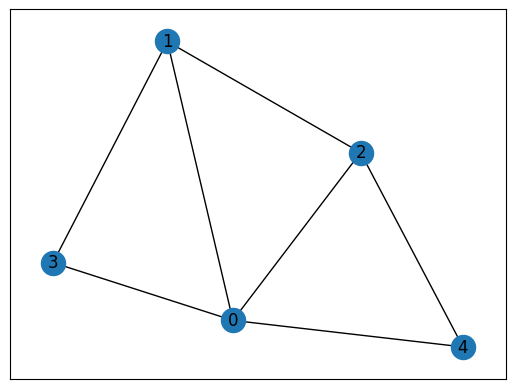

In [ ]:
# Graph Object
G = nx.Graph()
G.add_weighted_edges_from(graph)

# Print Graph
nx.draw_networkx(G)

Ejecutamos la función TSP que hemos creado para encontrar la ruta óptima que comienza en 0 y cuya segunda ciudad visitada es 2.

In [ ]:
Q,route = TSP(graph = graph, start = 0, second_city = 2, n_samples = 100, lagrange = lagrange)
print("Optimal Route: ", route)

The route is valid.
Optimal Route:  [0, 4, 2, 1, 3]
